In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_csv('/content/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [31]:
data.isna().sum()

,0
Formatted Date,0
Summary,0
Precip Type,517
Temperature (C),0
Apparent Temperature (C),0
Humidity,0
Wind Speed (km/h),0
Wind Bearing (degrees),0
Visibility (km),0
Loud Cover,0


In [32]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Selecting the Date column and my target forecast column

In [33]:
df = data[['Formatted Date', 'Temperature (C)']]

Changing the date column from object to datetime

In [37]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

In [38]:
df.head()

,Formatted Date,Temperature (C)
0,2006-03-31 22:00:00+00:00,9.472222
1,2006-03-31 23:00:00+00:00,9.355556
2,2006-04-01 00:00:00+00:00,9.377778
3,2006-04-01 01:00:00+00:00,8.288889
4,2006-04-01 02:00:00+00:00,8.755556


In [54]:
df.tail()

,Temperature (C)
Formatted Date,
2016-12-31 18:00:00+00:00,0.488889
2016-12-31 19:00:00+00:00,0.072222
2016-12-31 20:00:00+00:00,-0.233333
2016-12-31 21:00:00+00:00,-0.472222
2016-12-31 22:00:00+00:00,-0.677778


Setting the date column as the index

In [39]:
df.set_index('Formatted Date', inplace=True)

Checking for duplicate index and keeping the first one

In [42]:
df.index.duplicated().sum()

np.int64(24)

In [43]:
df = df[~df.index.duplicated(keep='first')]

Force Hourly Frequency

In [44]:
df = df.asfreq('H')

In [45]:
print(df.index.is_unique)
print(df.index.inferred_freq)


True
h


Creating the final times series for ARIMA

In [47]:
ts = df['Temperature (C)']
ts = ts.fillna(method='ffill')

Splitting the time series into training and test data

In [48]:
train = ts.iloc[:-3]
test  = ts.iloc[-3:]

Fit the ARIMA model

In [49]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

Forecasting the temperature for the next three hours

In [50]:
forecast = model_fit.forecast(steps=3)

Creating future timestamps

In [58]:
future_dates = pd.date_range(
    start=train.index[-1],
    periods=4,
    freq='H'
)[1:]

Plotting the forecast

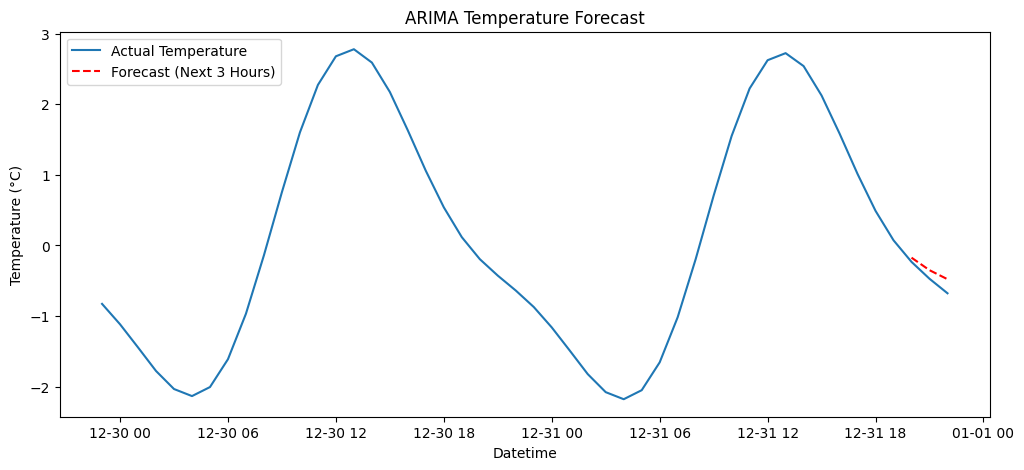

In [59]:
plt.figure(figsize=(12, 5))

plt.plot(ts[-48:], label='Actual Temperature')

plt.plot(future_dates, forecast, 'r--', label='Forecast (Next 3 Hours)')

plt.xlabel('Datetime')

plt.ylabel('Temperature (°C)')

plt.title('ARIMA Temperature Forecast')

plt.legend()

plt.show()

Model Evaluation

In [60]:
print(test)
print(forecast)

Formatted Date
2016-12-31 20:00:00+00:00   -0.233333
2016-12-31 21:00:00+00:00   -0.472222
2016-12-31 22:00:00+00:00   -0.677778
Freq: h, Name: Temperature (C), dtype: float64
2016-12-31 20:00:00+00:00   -0.173524
2016-12-31 21:00:00+00:00   -0.350818
2016-12-31 22:00:00+00:00   -0.478726
Freq: h, Name: predicted_mean, dtype: float64


In [61]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae:.3f} °C")
print(f"RMSE: {rmse:.3f} °C")


MAE: 0.127 °C
RMSE: 0.139 °C


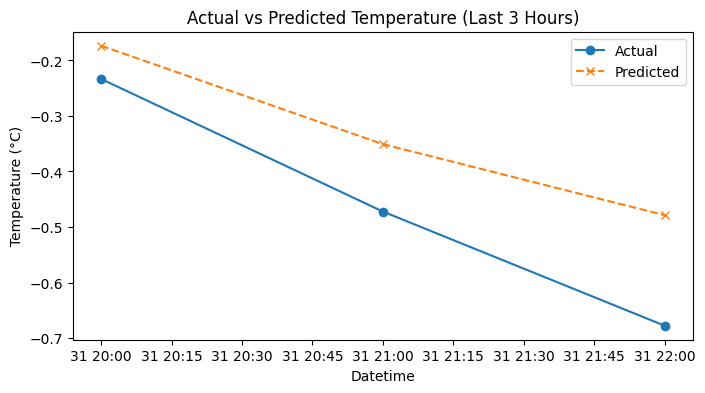

In [62]:
plt.figure(figsize=(8,4))
plt.plot(test.index, test.values, marker='o', label='Actual')
plt.plot(test.index, forecast.values, marker='x', linestyle='--', label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (Last 3 Hours)')
plt.legend()
plt.show()
